In [5]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time


#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement
import numpy as np

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.model_selection import KFold

import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

In [17]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None, group_to_drop = None, counts=True):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    print(df.head())
    df_2 = df.loc[df['Rank'] == rank]
    
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]

    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]

    if group_to_drop is not None:
        df_2 = df_2.loc[df_2[column_to_group] != group_to_drop]
                       
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
    
    # Dropping sparse columns
    if use_percent:
        counts = {}
        to_drop = []
        for column in table.columns:
            counts[column] = table[column].loc[table[column].notnull()].count() + table[column].loc[table[column] != 0].count()
            
            if counts[column] < table.shape[1]/100*percent:
                to_drop.append(column)
        table = table.drop(columns = to_drop)
    
    print("Shape of table:", table.shape)
    
    # Handling remaining Nan values and zero values
    table = table.fillna(0)
    table_repl = pd.DataFrame(multiplicative_replacement(table.values),
                      index=table.index,
                      columns=table.columns)
    

    
    # Addong "one" to all of them
    if False:
        columns = table_repl.columns
        def add_one(row):
            min_ab = max(row)
            for col in columns:
                if row[col] != 0 and row[col] < min_ab:
                    min_ab = row[col]
            for col in columns:
                row[col] = row[col] + min_ab
            return row

        table_repl = table_repl.apply(add_one,axis=1)
    
    # Switching from abundance to counts
    if False and counts:
        columns = table_repl.columns
        def calc_count(row):
            min_ab = min(row)
            to_mult = 1 / min_ab
            for col in columns:
                row[col] = round(row[col]*to_mult)
            return row

        table_repl = table_repl.apply(calc_count,axis=1)
    
    # Log of all abundance
    #table_repl = table_repl.apply(np.log,axis=1)

    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]

    return table_repl, grouping_ser

In [8]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']
['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metage

In [23]:
data = pd.read_csv("balance_FengQ_2015_metaphlan2_p_.csv", delimiter = '\t')

In [24]:
data.head()

,x
1,6.105360
2,6.181964
3,6.433774
5,7.264521
6,6.883195


In [31]:
y = pd.read_csv("y.csv", delimiter = ',')
y = y["STUDY_CONDITION"]

In [32]:
y.head()

0        CRC
1    control
2    control
3    control
4    control
Name: STUDY_CONDITION, dtype: object

In [9]:
def balance_for_sets(pos_set, neg_set):
    pos_k = pos_set.shape[1]
    neg_k = neg_set.shape[1]
    
    #sqrt((k1*k2)/(k1+k2))*(rowM(logc[,NUM])- rowM(logc[,DEN]))
    
    pos_bal = np.zeros((pos_set.shape[0]))
    for k in range(pos_k):
        pos_bal = np.add(pos_bal, np.log(pos_set[:,k]))
    pos_bal = pos_bal * 1/(pos_k)
    
    neg_bal = np.zeros((neg_set.shape[0]))
    for k in range(neg_k):
        neg_bal = neg_bal+np.log(neg_set[:,k])
    neg_bal = neg_bal * 1/(neg_k)
    
    B = np.sqrt((pos_k*neg_k)/(pos_k+neg_k)) * (pos_bal - neg_bal)
    
    return B

In [10]:
def get_table_from_logc(path_to_file):
    df = pd.read_csv(filename, delimiter = ',')

In [15]:
def test_for_AUC(dataset_name, method, rank, pos_set_names, neg_set_names, percent=0.2):
    start = time.time()

    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    
   
    table_repl, grouping_ser = get_table_and_grouping(dataset_name, table_files, rank = rank, percent=percent, group_to_drop="adenoma")
    
    #table_repl, grouping_ser = get_table_from_logc(path_to_file)
    # Split to train and test data
    X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2, random_state=1)
    
    # Training on training data with selected model, then test it on test data
    roc_auc, B_test, y_test = test_model(table_repl, grouping_ser, pos_set_names, neg_set_names)

    end2 = time.time()
    print("Elapsed time whole:", end2 - start)

    return roc_auc, B_test, y_test

In [148]:
data = pd.read_csv("balance_values_FengQ_2015_metaphlan2_p (1).tsv", delimiter = '\t')
y = pd.read_csv("y_FengQ_2015_metaphlan2_p (1).tsv", delimiter = '\t')

y = y.reset_index()
data = data.reset_index()

data = data.join(y, lsuffix = "_data", rsuffix="_y")

data["STUDY_CONDITION"] = data["x_y"]
data["Balance"] = data["x_data"]

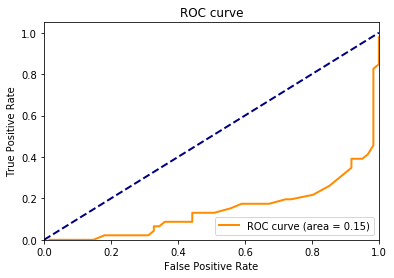

In [149]:
#ROC görbe számolása
fpr, tpr = ROC(data)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( 'ROC curve')
plt.legend(loc="lower right")

In [143]:
data = pd.read_csv("2_balance_FengQ_2015_metaphlan2_p_glm.csv", delimiter = '\t')
y = pd.read_csv("y.csv", delimiter = ',')
y = y["STUDY_CONDITION"]
data["STUDY_CONDITION"] = y
data["Balance"] = data["x"]

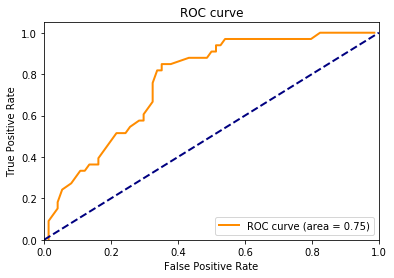

In [144]:
#ROC görbe számolása
fpr, tpr = ROC(data)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( 'ROC curve')
plt.legend(loc="lower right")

In [141]:
data = pd.read_csv("balance_FengQ_2015_metaphlan2_p_.csv", delimiter = '\t')
y = pd.read_csv("y.csv", delimiter = ',')
y = y["STUDY_CONDITION"]
data["STUDY_CONDITION"] = y
data["Balance"] = data["x"]

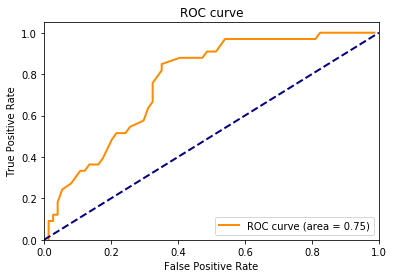

In [142]:
#ROC görbe számolása
fpr, tpr = ROC(data)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( 'ROC curve')
plt.legend(loc="lower right")

In [140]:
def ROC(df):
    TPR_list = []
    FPR_list = []
    df["TARGET"] = df["STUDY_CONDITION"] == "CRC"

    min_bal = df["Balance"].min()
    max_bal = df["Balance"].max()
    step = (max_bal-min_bal) / 100
    for treshold in np.arange(min_bal, max_bal, step):
        df["PREDICATE"] = [i>treshold for i in df["Balance"]]

        TP = len(df.loc[(df["PREDICATE"] == True )&
                                (df["TARGET"] == True)])
        FP = len(df.loc[(df["PREDICATE"] == True )&
                                (df["TARGET"] == False)])
        FN = len(df.loc[(df["PREDICATE"] == False )&
                                (df["TARGET"] == True)])
        TN = len(df.loc[(df["PREDICATE"] == False )&
                                (df["TARGET"] == False)])

        TPR = TP / (TP+FN)
        FPR = FP / (TN+FP)

        TPR_list.append(TPR)
        FPR_list.append(FPR)

    return FPR_list, TPR_list

In [19]:
def test_model(x_train, y_train, pos_set_names, neg_set_names):
    
    Y = [1 if v == "CRC" else 0 for v in y_train]
    pos_set = np.array(x_train[pos_set_names])
    neg_set = np.array(x_train[neg_set_names])
    
    B = balance_for_sets(pos_set, neg_set)

    x_train_2 = B.reshape(-1, 1)
    y_train_2 = Y

    order = list(y_train.drop_duplicates())

    #Balanceok ábrázolása
    plt.figure()
    df_train = pd.DataFrame(y_train)
    df_train["Balance"] = B
    sns.boxplot(x="STUDY_CONDITION", y="Balance", order=order, data=df_train).set_title("Train balances")

    
    #ROC görbe számolása
    fpr, tpr = ROC(df_train)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'ROC curve')
    plt.legend(loc="lower right")

    return roc_auc,

   Unnamed: 0  Sample_ID         Dataset Rank            Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    k        Bacteria   99.99747   
1           1  ERR688526  FengQ_2015.csv    k         Viruses    0.00253   
2           2  ERR688526  FengQ_2015.csv    p      Firmicutes   81.81372   
3           3  ERR688526  FengQ_2015.csv    p  Actinobacteria   12.04277   
4           4  ERR688526  FengQ_2015.csv    p   Bacteroidetes    4.97884   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        adult  
3        adult  
4      

ValueError: not enough values to unpack (expected 3, got 1)

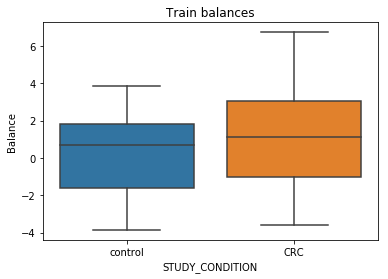

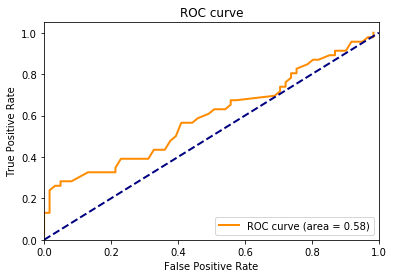

In [20]:
test_for_AUC("FengQ_2015", "Metaphlan", "s", pos_set_names =["Prevotella_copri",
    "Fusobacterium_nucleatum", "Lachnospiraceae_bacterium_7_1_58FAA"], neg_set_names=["Pseudomonas_unclassified"])

   Unnamed: 0  Sample_ID         Dataset Rank                 Name  Abundance  \
0           0  ERR688526  FengQ_2015.csv    U         unclassified      70.88   
1           1  ERR688526  FengQ_2015.csv    R                 root      29.12   
2           2  ERR688526  FengQ_2015.csv   R1   cellular organisms      29.11   
3           3  ERR688526  FengQ_2015.csv    D             Bacteria      29.05   
4           4  ERR688526  FengQ_2015.csv   D1  Terrabacteria group      25.38   

  STUDY_CONDITION BODY_SITE SUBJECTID COUNTRY              DISEASE  AGE  \
0         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
1         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
2         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
3         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   
4         adenoma     stool  SID31282     AUT  adenoma;fatty_liver   63   

  AGE_CATEGORY  
0        adult  
1        adult  
2        ad

(0.3958333333333333,
 array([2.84982851, 3.07448733, 2.46563568, 3.19545254, 2.89194392,
        2.81700078, 2.68461152, 3.01439468, 2.92997559, 2.461896  ,
        2.47862638, 3.03582555, 2.92508889, 2.53839873, 2.827835  ,
        2.30548984, 1.55591979, 2.82497653, 2.74190987, 3.24775362,
        2.56307921, 2.51434021]),
 Sample_ID
 ERR688642        CRC
 ERR688511    control
 ERR688638        CRC
 ERR688617    control
 ERR688544    control
 ERR688618        CRC
 ERR688563    control
 ERR710428    control
 ERR688639        CRC
 ERR688537    control
 ERR688599    control
 ERR688622    control
 ERR688515        CRC
 ERR688554    control
 ERR710426    control
 ERR688547        CRC
 ERR688581        CRC
 ERR688614    control
 ERR688513        CRC
 ERR688644        CRC
 ERR688648    control
 ERR688651        CRC
 Name: STUDY_CONDITION, dtype: object)

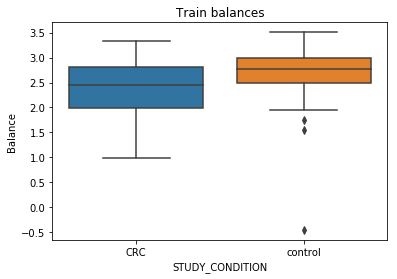

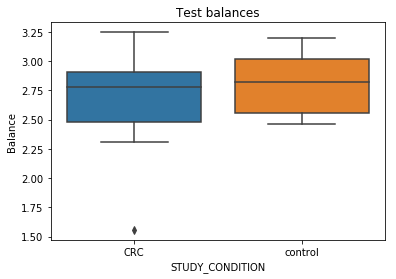

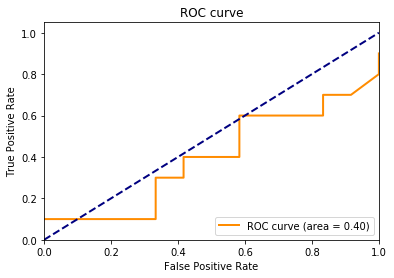

In [21]:
test_for_AUC("FengQ_2015", "Kraken", "c", neg_set_names=["Flavobacteriia",
    "Fusobacteriia", "Mammalia"], pos_set_names=["Clostridia", "Spirochaetia"])